In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import torchvision.transforms as T

In [ ]:
import re

folder = "C:/fire_detection/corsican_data/all_images"

for fname in os.listdir(folder):
    if any(tag in fname for tag in ['_rgb', '_nir', '_gt']):
        base, ext = os.path.splitext(fname)

        # Match patterns like seq01_rgb_001 or 001_rgb
        match = re.match(r'(.*?)(_rgb|_nir|_gt)(_?\d+)?', base)
        if match:
            group = match.group(1).replace('_', '-')  # e.g., seq01 or 001
            ftype = match.group(2)[1:]                # rgb / ir / gt
            frame = match.group(3) or ''              # _001 or ''

            # Remove leading underscore from frame
            frame = frame.lstrip('_')

            new_name = f"{group}-{frame}_{ftype}{ext}" if frame else f"{group}_{ftype}{ext}"
            os.rename(os.path.join(folder, fname), os.path.join(folder, new_name))
            print(f"Renamed: {fname} → {new_name}")


Renamed: 078_nir.png → 078_nir.png
Renamed: 318_nir.png → 318_nir.png
Renamed: 319_nir.png → 319_nir.png
Renamed: 320_nir.png → 320_nir.png
Renamed: 321_nir.png → 321_nir.png
Renamed: 501_nir.png → 501_nir.png
Renamed: 502_nir.png → 502_nir.png
Renamed: 503_nir.png → 503_nir.png
Renamed: 504_nir.png → 504_nir.png
Renamed: 505_nir.png → 505_nir.png
Renamed: 506_nir.png → 506_nir.png
Renamed: 507_nir.png → 507_nir.png
Renamed: 508_nir.png → 508_nir.png
Renamed: 509_nir.png → 509_nir.png
Renamed: 510_nir.png → 510_nir.png
Renamed: 511_nir.png → 511_nir.png
Renamed: 512_nir.png → 512_nir.png
Renamed: 513_nir.png → 513_nir.png
Renamed: 514_nir.png → 514_nir.png
Renamed: 515_nir.png → 515_nir.png
Renamed: 516_nir.png → 516_nir.png
Renamed: 517_nir.png → 517_nir.png
Renamed: 518_nir.png → 518_nir.png
Renamed: 519_nir.png → 519_nir.png
Renamed: 520_nir.png → 520_nir.png
Renamed: 521_nir.png → 521_nir.png
Renamed: 522_nir.png → 522_nir.png
Renamed: 523_nir.png → 523_nir.png
Renamed: 524_nir.png

In [11]:


base_names = sorted(list(set(
            f.split('_')[0] 
            for f in os.listdir("C:\\fire_detection\corsican_data\\all_images")
            if '_rgb' in f
        )))

base_names

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Admin\AppData\Local\Temp\ipykernel_26220\1792945694.py:3: SyntaxWarning: invalid escape sequence '\c'
  for f in os.listdir("C:\\fire_detection\corsican_data\\all_images")


['001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',


In [2]:
class FireDatasetRGBIR(Dataset):
    def __init__(self, root_dir, image_size=(224, 224), use_ir=True):
        self.root_dir = root_dir
        self.image_size = image_size
        self.use_ir = use_ir

        # Collect base names (like img_001, img_002)
        self.base_names = sorted(list(set(
            f.split('_')[0] 
            for f in os.listdir(root_dir)
            if '_rgb' in f
        )))

        # Transforms
        self.rgb_transform = T.Compose([
            T.Resize(self.image_size),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
        ])
        self.ir_transform = T.Compose([
            T.Resize(self.image_size),
            T.ToTensor()  # Will be [1, H, W]
        ])
        self.mask_transform = T.Compose([
            T.Resize(self.image_size),
            T.ToTensor()  # Assumes mask is binary (0 or 255)
        ])
    def unnormalize(self, tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        return tensor * std + mean

    def __len__(self):
        return len(self.base_names)

    def __getitem__(self, idx):
        base = self.base_names[idx]

        rgb_path = os.path.join(self.root_dir, f"{base}_rgb.png")
        mask_path = os.path.join(self.root_dir, f"{base}_gt.png")
        ir_path = os.path.join(self.root_dir, f"{base}_nir.png")

        rgb = Image.open(rgb_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # binary mask

        rgb = self.rgb_transform(rgb)
        mask = self.mask_transform(mask)

        if self.use_ir and os.path.exists(ir_path):
            ir = Image.open(ir_path).convert('L')  # grayscale IR
            ir = self.ir_transform(ir)
            x = torch.cat([rgb, ir], dim=0)  # [4, H, W]
        else:
            x = rgb  # [3, H, W]

        # Make sure mask is binary (0 or 1)
        mask = (mask > 0).float()

        return x, mask


In [3]:
dataset = FireDatasetRGBIR(root_dir="corsican_data/all_images", use_ir= False)
len(dataset.base_names)

1135

In [4]:
first_x, first_y = dataset.__getitem__(0)



In [5]:
def unnormalize(tensor, mean, std):
        mean = torch.tensor(mean).reshape(3, 1, 1)
        std = torch.tensor(std).reshape(3, 1, 1)
        return tensor * std + mean


In [6]:
def show_image_and_mask(rgb, mask):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    rgb = unnormalize(rgb, mean, std)

    # Prepare images
    rgb_np = rgb.permute(1, 2, 0).numpy().clip(0, 1)  # [H, W, 3]
    if mask.ndim == 3:
        mask_np = mask.squeeze(0).numpy()             # [H, W]
    else:
        mask_np = mask.numpy()

    # Plot side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(rgb_np)
    ax[0].set_title("RGB Image")
    ax[0].axis("off")

    ax[1].imshow(mask_np, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

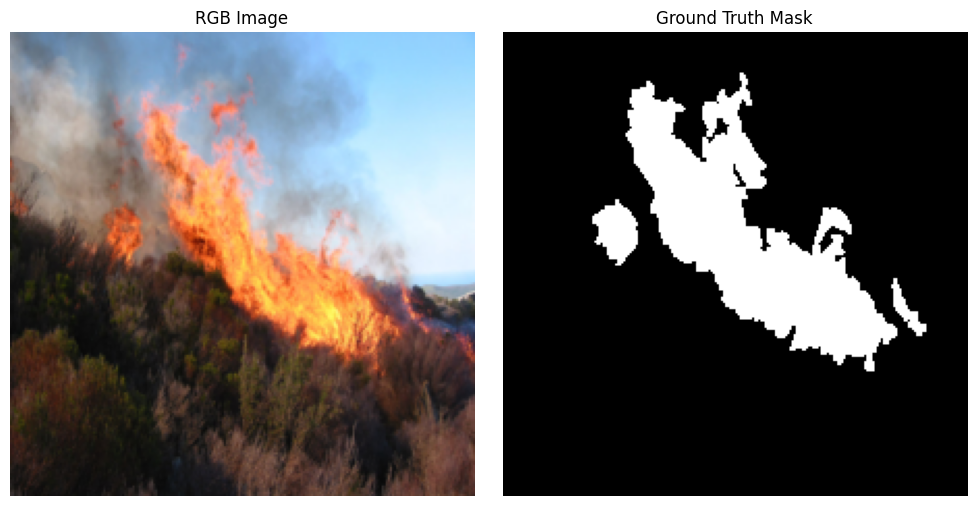

In [7]:
show_image_and_mask(first_x, first_y)

In [8]:
print(torch.unique(first_y)) # Black or white image

tensor([0., 1.])


In [9]:
class UNetSimple(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def CBR(in_c, out_c):  # conv → BN → ReLU
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        
        self.pool = nn.MaxPool2d(2, 2) # halves the dimensions

        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = CBR(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d2 = self.dec2(torch.cat([self.up2(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out(d1)  # output logits (no sigmoid here!)
    
flatten = nn.Flatten()
    
model = UNetSimple()
model.state_dict()



OrderedDict([('enc1.0.weight',
              tensor([[[[-0.0357, -0.0824, -0.1113],
                        [-0.0841,  0.1787, -0.0649],
                        [-0.1577, -0.1701, -0.0916]],
              
                       [[ 0.1625, -0.1517,  0.0804],
                        [ 0.0887, -0.0836,  0.0017],
                        [ 0.0096, -0.0435, -0.1298]],
              
                       [[ 0.1012, -0.1492, -0.1738],
                        [ 0.1173,  0.0988,  0.1744],
                        [ 0.1669,  0.1300, -0.1632]]],
              
              
                      [[[ 0.1653, -0.1332, -0.1690],
                        [-0.1002,  0.1150, -0.0074],
                        [-0.1517, -0.0620,  0.0639]],
              
                       [[-0.1470,  0.0160, -0.1225],
                        [-0.1224,  0.0354,  0.1270],
                        [ 0.1378,  0.0750, -0.0683]],
              
                       [[-0.0765,  0.1209, -0.0020],
                        [

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 905,025


In [11]:
from torch.utils.data import random_split

torch.manual_seed(42)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [12]:
len(train_dataset), len(test_dataset)

(908, 227)

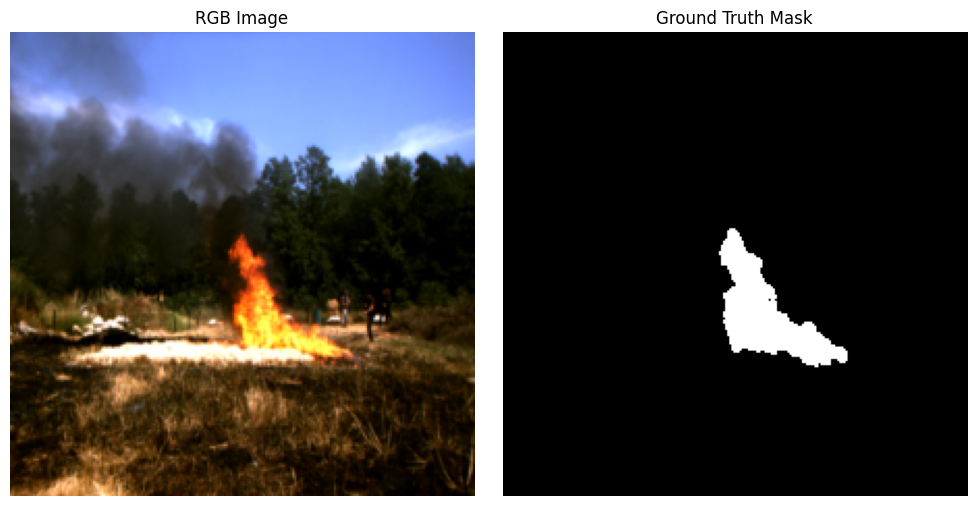

In [13]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

X, y = next(iter(train_loader))
# len(X), len(y)
show_image_and_mask(X[2], y[2])

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
model = model.to(device)

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 1e-3)

In [17]:
from tqdm import tqdm

def train_segmentation_model(model, train_loader, val_loader, device, num_epochs=10, loss_fn=loss_fn, optimizer=optimizer):
    # model = model.to(device)

    # criterion = torch.nn.BCEWithLogitsLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)              # [B, 3 or 4, H, W]
            masks = masks.to(device).float()        # [B, 1, H, W], float

            
            outputs = model(images)                 # [B, 1, H, W], logits
            loss = loss_fn(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # ----- Validation -----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to(device)
                masks = masks.to(device).float()

                outputs = model(images)
                loss = loss_fn(outputs, masks)

                val_loss += loss.item() * images.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print("-" * 50)

    return model


In [18]:
train_segmentation_model(model=model,
                         train_loader=train_loader,
                         val_loader=test_loader,
                         device=device,
                         num_epochs=5,
                            )

Epoch 1/5 - Validation: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]



Epoch 1:
Train Loss: 0.2762 | Val Loss: 0.1713
--------------------------------------------------


Epoch 2/5 - Validation: 100%|██████████| 29/29 [00:24<00:00,  1.21it/s]



Epoch 2:
Train Loss: 0.1543 | Val Loss: 0.1383
--------------------------------------------------


Epoch 3/5 - Validation: 100%|██████████| 29/29 [00:19<00:00,  1.48it/s]



Epoch 3:
Train Loss: 0.1404 | Val Loss: 0.1340
--------------------------------------------------


Epoch 4/5 - Validation: 100%|██████████| 29/29 [00:18<00:00,  1.58it/s]



Epoch 4:
Train Loss: 0.1359 | Val Loss: 0.1230
--------------------------------------------------


Epoch 5/5 - Validation: 100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


Epoch 5:
Train Loss: 0.1355 | Val Loss: 0.1248
--------------------------------------------------


UNetSimple(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [21]:
torch.save(model.state_dict(), 'unet_simple_fire_segmentation.pth')

In [19]:
def show_prediction_and_mask(pred, mask):


    pred = torch.round(torch.sigmoid(pred)).detach().cpu()
    mask = mask.detach().cpu()
    if mask.ndim == 3:
        mask_np = mask.squeeze(0).numpy()             # [H, W]
    else:
        mask_np = mask.numpy()

    if pred.ndim == 3:
        pred_np = pred.squeeze(0).numpy()
    elif pred.ndim == 4:
        pred_np = pred.squeeze(0).squeeze(0).numpy()           # [H, W]
    else:
        pred_np = pred.numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(pred_np, cmap="gray")
    ax[0].set_title("Prediction Mask")
    ax[0].axis("off")

    ax[1].imshow(mask_np, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

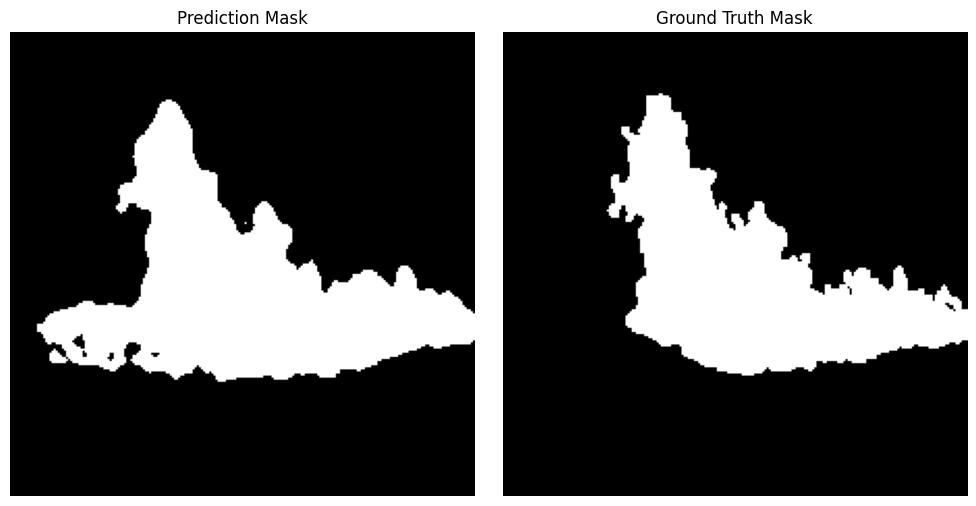

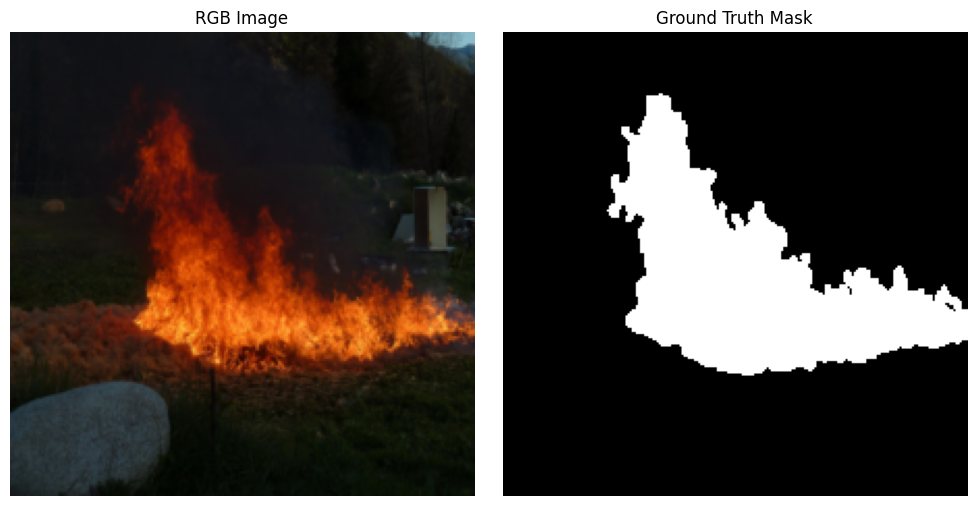

In [20]:
X_first, y_first = train_dataset[1]
X_first = X_first.to(device)
y_first_pred = model(X_first.unsqueeze(dim=0))
show_prediction_and_mask(torch.round(torch.sigmoid(y_first_pred)).squeeze().detach().cpu(), y_first.squeeze())
show_image_and_mask(X_first.cpu(), y_first.squeeze())

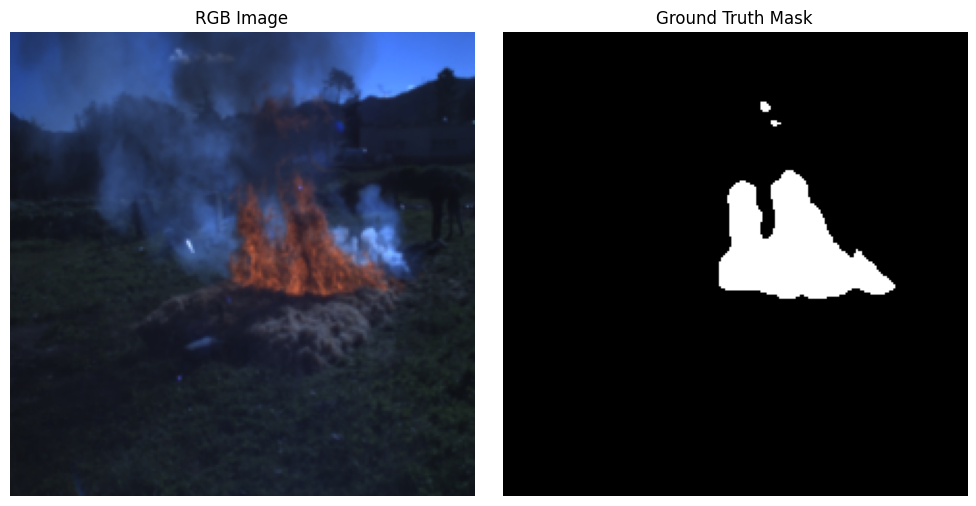

In [22]:
X, y = test_dataset[4]
X = X.to(device)
y_pred = model(X.unsqueeze(dim = 0))
# y_pred = y_pred.cpu().detach().numpy()
y_pred = torch.round(torch.sigmoid(y_pred)).squeeze().detach().cpu()

show_image_and_mask(X.cpu(), y_pred)

In [23]:
def accuracy_fn(pred_mask, gt):

    pred_mask = torch.round(torch.sigmoid(torch.flatten(pred_mask))).cpu()
    gt = torch.flatten(gt).cpu()

    correct_pixels = torch.eq(pred_mask, gt).sum().item()
    acc_score = correct_pixels/len(gt)
    return acc_score

In [24]:
def intersection_over_union(preds: torch.Tensor, targets: torch.Tensor) -> float:
    eps = 1e-5
    probs = torch.sigmoid(preds)
    preds_bin = (probs < 0.5).float() # fire=1, background=0


    targets = 1.0 - targets  # Flip: fire=1, background=0

    preds_flat = preds_bin.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1) - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [25]:
def dice_coefficient(preds: torch.Tensor, targets: torch.Tensor) -> float:
    eps = 1e-5
    probs = torch.sigmoid(preds)
    preds_bin = (probs < 0.5).float() # fire=1, background=0


    targets = 1.0 - targets  # Flip: fire=1, background=0

    preds_flat = preds_bin.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1)

    dc = (2 * (intersection + eps)) / (union + eps)
    return dc.mean().item()


In [26]:
# Validation loop
total_acc = 0.0
total_iou = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)
        loss = loss_fn(logits, masks.float())

        acc = accuracy_fn(logits, masks)
        iou = intersection_over_union(logits, masks)
        total_iou += iou * images.size(0)
        total_acc += acc * images.size(0)

avg_test_iou = total_iou / len(test_loader.dataset)
avg_test_acc = total_acc / len(test_loader.dataset)
print(f"Testing Accuracy: {avg_test_acc:.4f}")
print(f"Testing Intersection Over Union: {avg_test_iou:.4f}")


Testing Accuracy: 0.9627
Testing Intersection Over Union: 0.9547


In [27]:
train_acc = 0.0
train_iou = 0.0
with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)
        loss = loss_fn(logits, masks.float())

        acc = accuracy_fn(logits, masks)
        iou = intersection_over_union(logits, masks)
        train_iou += iou * images.size(0)
        train_acc += acc * images.size(0)

avg_train_iou = train_iou / len(train_loader.dataset)
avg_train_acc = train_acc / len(train_loader.dataset)
print(f"Training Accuracy: {avg_train_acc:.4f}")
print(f"Training Intersection Over Union: {avg_train_iou:.4f}")


Training Accuracy: 0.9596
Training Intersection Over Union: 0.9485


0.994140625


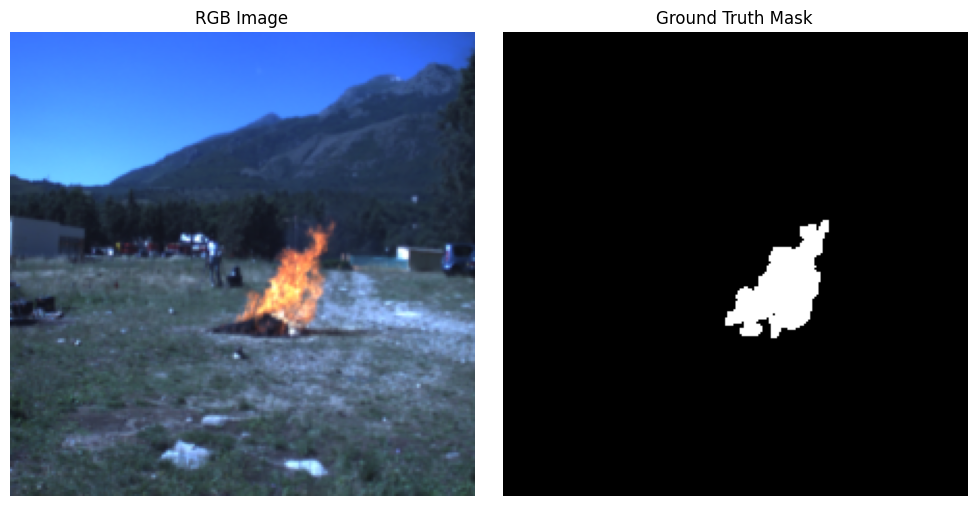

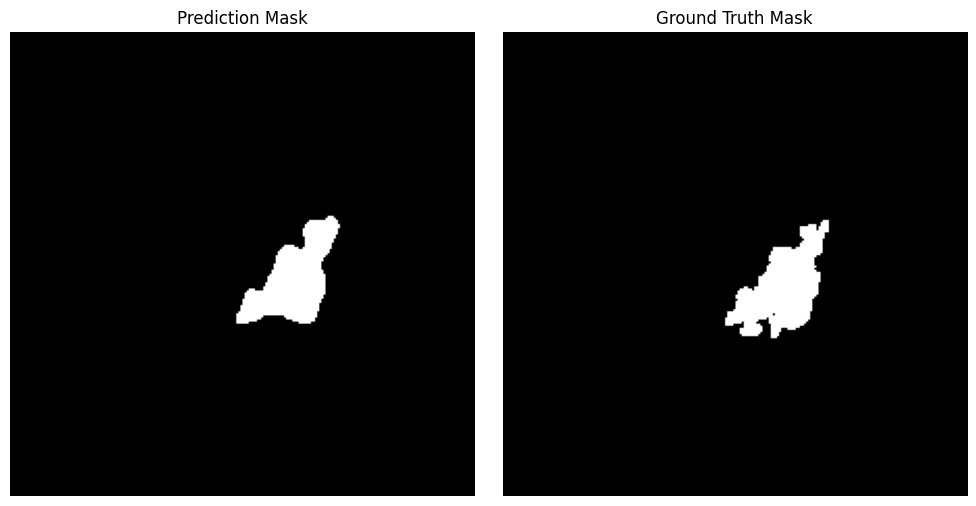

In [174]:
X, y = train_dataset[667]
X = X.to(device)
y_pred = model(X.unsqueeze(dim=0))
print(accuracy_fn(y_pred, y))
show_image_and_mask(X.cpu(), y)
show_prediction_and_mask(y_pred, y)


In [75]:
accuracies = {"light_model": None, "unet": None, "deeplab": None}
ious = {"light_model": None, "unet": None, "deeplab": None}

In [40]:
class LighterUnet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def CBR(in_c, out_c):  # conv → BN → ReLU
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = CBR(in_channels, 32)
        self.enc2 = CBR(32, 64)
        self.enc3 = CBR(64, 128)

        self.pool = nn.MaxPool2d(2, 2) # halves the dimensions

        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = CBR(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1 = CBR(64, 32)

        self.out = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d2 = self.dec2(torch.cat([self.up2(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out(d1)  # output logits (no sigmoid here!
    
light_model = LighterUnet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
light_optimizer = torch.optim.Adam(params=light_model.parameters(), lr=1e-3 )

        


In [41]:
total_params = sum(p.numel() for p in light_model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 227,233


In [42]:
train_segmentation_model(model=light_model,
                         train_loader=train_loader,
                         val_loader=test_loader,
                         device=device,
                         num_epochs=10,
                         optimizer=light_optimizer,
                         loss_fn=loss_fn
                            )

Epoch 1/10 - Validation: 100%|██████████| 29/29 [00:24<00:00,  1.18it/s]



Epoch 1:
Train Loss: 0.2759 | Val Loss: 0.1586
--------------------------------------------------


Epoch 2/10 - Validation: 100%|██████████| 29/29 [00:22<00:00,  1.27it/s]



Epoch 2:
Train Loss: 0.1628 | Val Loss: 0.1332
--------------------------------------------------


Epoch 3/10 - Validation: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]



Epoch 3:
Train Loss: 0.1443 | Val Loss: 0.1276
--------------------------------------------------


Epoch 4/10 - Validation: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]



Epoch 4:
Train Loss: 0.1346 | Val Loss: 0.1224
--------------------------------------------------


Epoch 5/10 - Validation: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]



Epoch 5:
Train Loss: 0.1277 | Val Loss: 0.1239
--------------------------------------------------


Epoch 6/10 - Validation: 100%|██████████| 29/29 [00:23<00:00,  1.21it/s]



Epoch 6:
Train Loss: 0.1284 | Val Loss: 0.1099
--------------------------------------------------


Epoch 7/10 - Validation: 100%|██████████| 29/29 [00:21<00:00,  1.32it/s]



Epoch 7:
Train Loss: 0.1213 | Val Loss: 0.1089
--------------------------------------------------


Epoch 8/10 - Validation: 100%|██████████| 29/29 [00:27<00:00,  1.04it/s]



Epoch 8:
Train Loss: 0.1226 | Val Loss: 0.1170
--------------------------------------------------


Epoch 9/10 - Validation: 100%|██████████| 29/29 [00:30<00:00,  1.05s/it]



Epoch 9:
Train Loss: 0.1173 | Val Loss: 0.1155
--------------------------------------------------


Epoch 10/10 - Validation: 100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Epoch 10:
Train Loss: 0.1140 | Val Loss: 0.1051
--------------------------------------------------


LighterUnet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [80]:
torch.save(light_model.state_dict(), 'light_model.pth')

In [31]:
import segmentation_models_pytorch as smp

def get_model(name: str, in_channels=3):
    if name == "unet":
        return smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",
                        in_channels=in_channels, classes=1)
    elif name == "deeplabv3":
        return smp.DeepLabV3(encoder_name="resnet34", encoder_weights="imagenet",
                             in_channels=in_channels, classes=1)
    elif name == "segnet":
        return smp.SegmentationModel(
            encoder_name="vgg11_bn",
            encoder_weights="imagenet",
            decoder_channels=(256, 128, 64, 32, 16),
            in_channels=in_channels,
            classes=1
        )
    else:
        raise ValueError("Unsupported model")

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
# Validation loop
total_acc = 0.0
total_iou = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = light_model(images)
        loss = loss_fn(logits, masks.float())

        acc = accuracy_fn(logits, masks)
        iou = intersection_over_union(logits, masks)
        total_iou += iou * images.size(0)
        total_acc += acc * images.size(0)

avg_test_iou = total_iou / len(test_loader.dataset)
avg_test_acc = total_acc / len(test_loader.dataset)
print(f"Testing Accuracy: {avg_test_acc:.4f}")
accuracies['light_model'] = avg_test_acc
print(f"Testing Intersection Over Union: {avg_test_iou:.4f}")
ious['light_model'] = avg_test_iou

Testing Accuracy: 0.9685
Testing Intersection Over Union: 0.9632


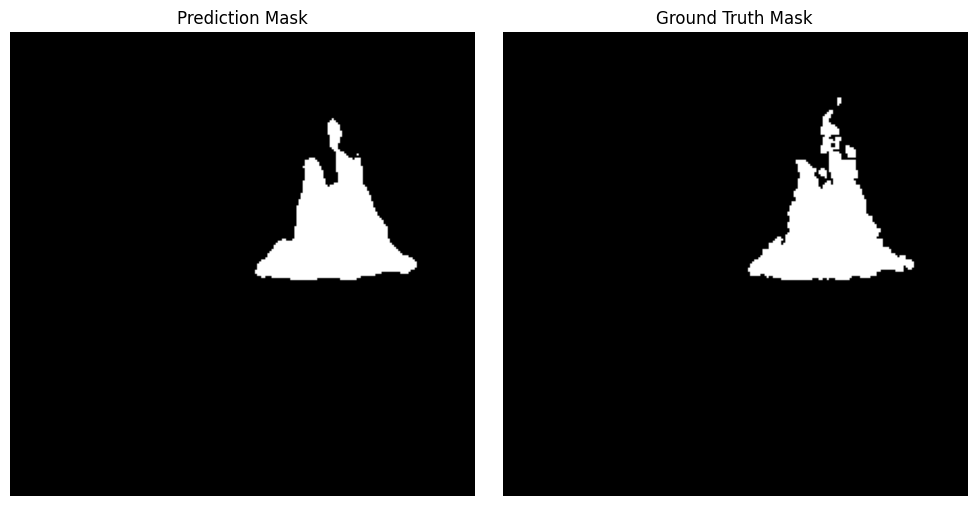

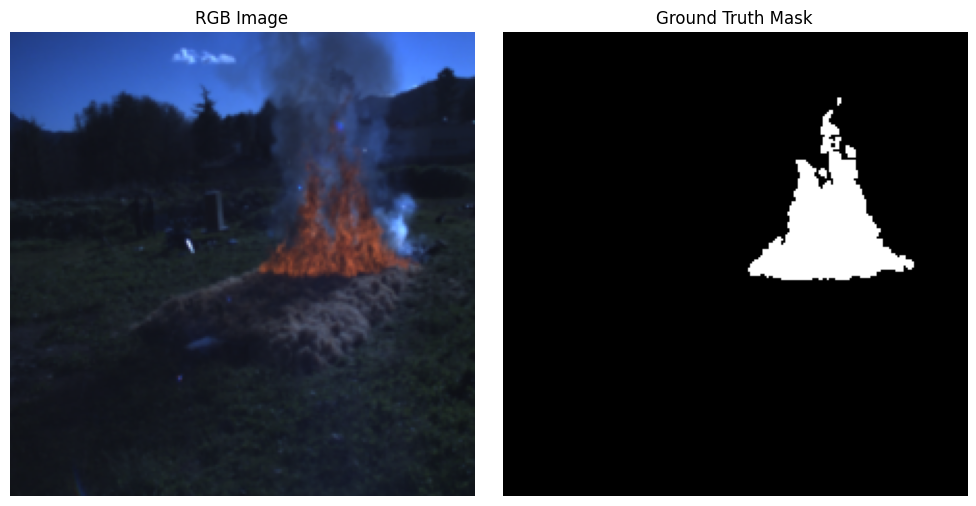

In [50]:
X, y = train_dataset[11]
X = X.to(device)
y_pred = light_model(X.unsqueeze(dim=0))
show_prediction_and_mask(y_pred, y)
show_image_and_mask(X.cpu(), y)

In [62]:
unet_model = get_model("unet")
total_params = sum(p.numel() for p in unet_model.parameters())
print(f"Total parameters (UNet): {total_params:,}")

Total parameters (UNet): 24,436,369


In [63]:
deeplab_model = get_model("deeplabv3")
total_params = sum(p.numel() for p in deeplab_model.parameters())
print(f"Total parameters (DeeplabV3): {total_params:,}")

Total parameters (DeeplabV3): 26,007,105


In [64]:
unet_model = unet_model.to(device)
deeplab_model = deeplab_model.to(device)

In [65]:
loss_fn = nn.BCEWithLogitsLoss()
unet_optim = torch.optim.Adam(params=unet_model.parameters(), lr=1e-3) 

In [66]:
train_segmentation_model(model=unet_model, 
                         train_loader=train_loader,
                         val_loader=test_loader,
                         device=device,
                         num_epochs=10,
                         loss_fn=loss_fn,
                         optimizer=unet_optim)

Epoch 1/10 - Validation: 100%|██████████| 29/29 [00:23<00:00,  1.25it/s]



Epoch 1:
Train Loss: 0.2308 | Val Loss: 0.1194
--------------------------------------------------


Epoch 2/10 - Validation: 100%|██████████| 29/29 [00:23<00:00,  1.25it/s]



Epoch 2:
Train Loss: 0.1336 | Val Loss: 0.1404
--------------------------------------------------


Epoch 3/10 - Validation: 100%|██████████| 29/29 [00:22<00:00,  1.26it/s]



Epoch 3:
Train Loss: 0.1290 | Val Loss: 0.1166
--------------------------------------------------


Epoch 4/10 - Validation: 100%|██████████| 29/29 [00:23<00:00,  1.23it/s]



Epoch 4:
Train Loss: 0.1173 | Val Loss: 0.1114
--------------------------------------------------


Epoch 5/10 - Validation: 100%|██████████| 29/29 [00:23<00:00,  1.26it/s]



Epoch 5:
Train Loss: 0.1076 | Val Loss: 0.0996
--------------------------------------------------


Epoch 6/10 - Validation: 100%|██████████| 29/29 [00:25<00:00,  1.15it/s]



Epoch 6:
Train Loss: 0.1117 | Val Loss: 0.1082
--------------------------------------------------


Epoch 7/10 - Validation: 100%|██████████| 29/29 [00:32<00:00,  1.14s/it]



Epoch 7:
Train Loss: 0.1003 | Val Loss: 0.0975
--------------------------------------------------


Epoch 8/10 - Validation: 100%|██████████| 29/29 [00:28<00:00,  1.00it/s]



Epoch 8:
Train Loss: 0.1035 | Val Loss: 0.0942
--------------------------------------------------


Epoch 9/10 - Validation: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 9:
Train Loss: 0.0996 | Val Loss: 0.1262
--------------------------------------------------


Epoch 10/10 - Validation: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch 10:
Train Loss: 0.0998 | Val Loss: 0.0915
--------------------------------------------------


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [77]:
# Validation loop
total_acc = 0.0
total_iou = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = unet_model(images)
        loss = loss_fn(logits, masks.float())

        acc = accuracy_fn(logits, masks)
        iou = intersection_over_union(logits, masks)
        total_iou += iou * images.size(0)
        total_acc += acc * images.size(0)

avg_test_iou = total_iou / len(test_loader.dataset)
avg_test_acc = total_acc / len(test_loader.dataset)
print(f"Testing Accuracy (UNET): {avg_test_acc:.4f}")
accuracies['unet'] = avg_test_acc
print(f"Testing Intersection Over Union (UNET): {avg_test_iou:.4f}")
ious['unet'] = avg_test_iou

Testing Accuracy (UNET): 0.9707
Testing Intersection Over Union (UNET): 0.9664


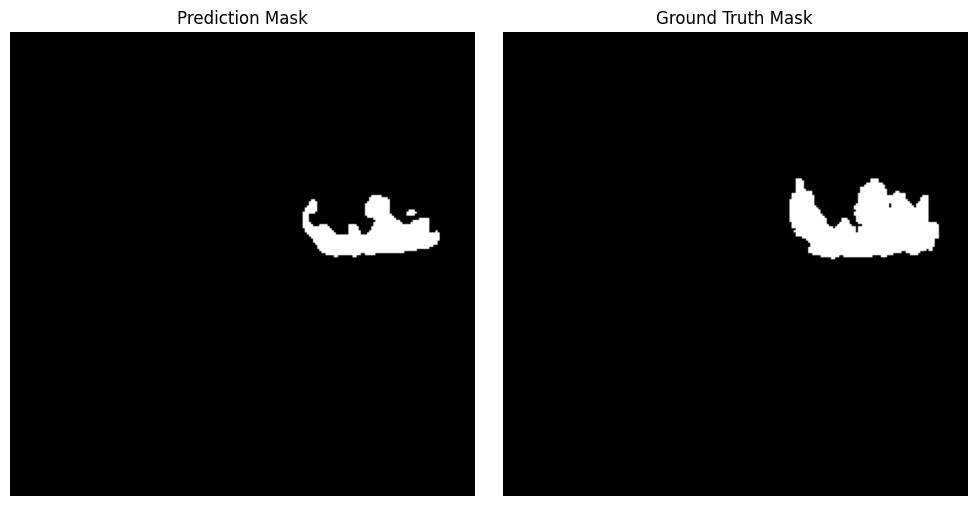

In [72]:
X, y = test_dataset[12]
X = X.to(device)
y_pred = unet_model(X.unsqueeze(dim=0))

show_prediction_and_mask(y_pred, y)

In [67]:
loss_fn = nn.BCEWithLogitsLoss()
deeplab_optim = torch.optim.Adam(params=deeplab_model.parameters(), lr=1e-3) 

In [68]:
train_segmentation_model(model=deeplab_model, 
                         train_loader=train_loader,
                         val_loader=test_loader,
                         device=device,
                         num_epochs=10,
                         loss_fn=loss_fn,
                         optimizer=deeplab_optim)

Epoch 1/10 - Validation: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1:
Train Loss: 0.2313 | Val Loss: 0.1349
--------------------------------------------------


Epoch 2/10 - Validation: 100%|██████████| 29/29 [00:22<00:00,  1.30it/s]



Epoch 2:
Train Loss: 0.1230 | Val Loss: 0.1021
--------------------------------------------------


Epoch 3/10 - Validation: 100%|██████████| 29/29 [00:25<00:00,  1.12it/s]



Epoch 3:
Train Loss: 0.1176 | Val Loss: 0.2466
--------------------------------------------------


Epoch 4/10 - Validation: 100%|██████████| 29/29 [00:28<00:00,  1.01it/s]



Epoch 4:
Train Loss: 0.1347 | Val Loss: 0.1045
--------------------------------------------------


Epoch 5/10 - Validation: 100%|██████████| 29/29 [00:32<00:00,  1.11s/it]



Epoch 5:
Train Loss: 0.1060 | Val Loss: 0.0992
--------------------------------------------------


Epoch 6/10 - Validation: 100%|██████████| 29/29 [00:39<00:00,  1.35s/it]



Epoch 6:
Train Loss: 0.1026 | Val Loss: 0.0801
--------------------------------------------------


Epoch 7/10 - Validation: 100%|██████████| 29/29 [00:39<00:00,  1.38s/it]



Epoch 7:
Train Loss: 0.1021 | Val Loss: 0.1159
--------------------------------------------------


Epoch 8/10 - Validation: 100%|██████████| 29/29 [00:24<00:00,  1.19it/s]



Epoch 8:
Train Loss: 0.1041 | Val Loss: 0.0825
--------------------------------------------------


Epoch 9/10 - Validation: 100%|██████████| 29/29 [00:25<00:00,  1.16it/s]



Epoch 9:
Train Loss: 0.0897 | Val Loss: 0.0935
--------------------------------------------------


Epoch 10/10 - Validation: 100%|██████████| 29/29 [00:25<00:00,  1.14it/s]


Epoch 10:
Train Loss: 0.0839 | Val Loss: 0.1118
--------------------------------------------------


DeepLabV3(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [78]:
# Validation loop
total_acc = 0.0
total_iou = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = deeplab_model(images)
        loss = loss_fn(logits, masks.float())

        acc = accuracy_fn(logits, masks)
        iou = intersection_over_union(logits, masks)
        total_iou += iou * images.size(0)
        total_acc += acc * images.size(0)

avg_test_iou = total_iou / len(test_loader.dataset)
avg_test_acc = total_acc / len(test_loader.dataset)
print(f"Testing Accuracy (DeepLabV3): {avg_test_acc:.4f}")
accuracies["deeplab"] = avg_test_acc
print(f"Testing Intersection Over Union (DeepLabV3): {avg_test_iou:.4f}")
ious["deeplab"] = avg_test_iou

Testing Accuracy (DeepLabV3): 0.9677
Testing Intersection Over Union (DeepLabV3): 0.9624


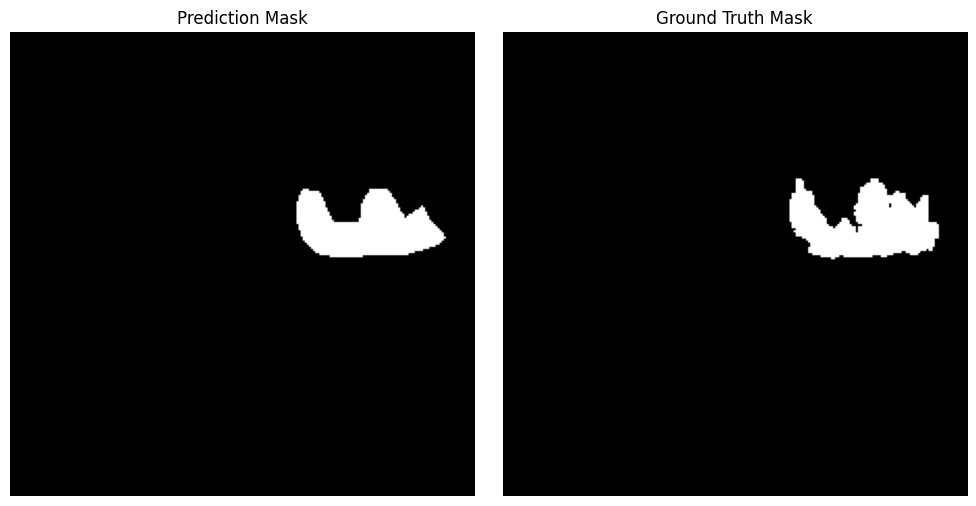

In [73]:
X, y = test_dataset[12]
X = X.to(device)
y_pred = deeplab_model(X.unsqueeze(dim=0))

show_prediction_and_mask(y_pred, y)

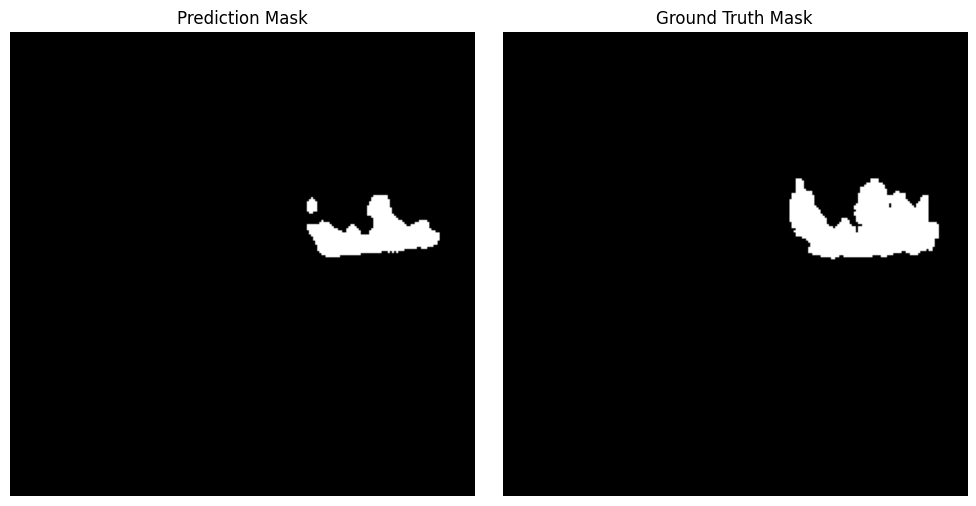

In [74]:
X, y = test_dataset[12]
X = X.to(device)
y_pred = light_model(X.unsqueeze(dim=0))

show_prediction_and_mask(y_pred, y)

In [79]:
accuracies, ious

({'light_model': 0.9684641340016183,
  'unet': 0.9706624751359796,
  'deeplab': 0.9676577214723995},
 {'light_model': 0.9631991893184343,
  'unet': 0.9664005729070319,
  'deeplab': 0.962432961369401})

In [81]:
torch.save(unet_model.state_dict(), "unet_weights.pth")


In [82]:
torch.save(deeplab_model.state_dict(), "deeplab_weights.pth")


In [ ]:
models = list(ious.keys())
ious = list(ious.values())
accs = list(accuracies.values())

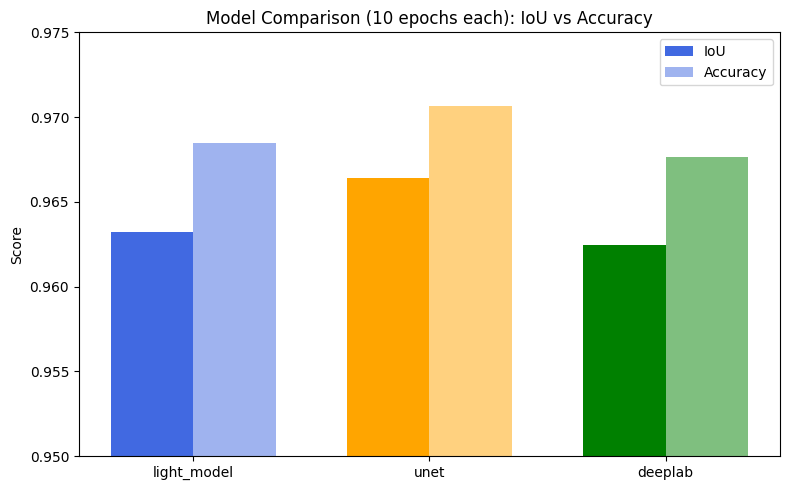

In [ ]:
# Colors
colors = ['royalblue', 'orange', 'green']

# Plot
x = range(len(models))
bar_width = 0.35

plt.figure(figsize=(8, 5))

# Plot IoU
plt.bar([i - bar_width/2 for i in x], ious, width=bar_width, label='IoU', color=colors)
# Plot Accuracy
plt.bar([i + bar_width/2 for i in x], accs, width=bar_width, label='Accuracy', color=colors, alpha=0.5)

# Labels and Title
plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Model Comparison (10 epochs each): IoU vs Accuracy")
plt.ylim(0.95, 0.975)
plt.legend()

plt.tight_layout()
plt.show()